In [1]:
import os 
import pandas as pd
import glob
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
import cv2
from sklearn.metrics import multilabel_confusion_matrix
import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, roc_curve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from PIL import Image
import random
import albumentations as A
import matplotlib.cm as cm
import plotly.express as px
import plotly.figure_factory as ff
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

2023-07-26 09:03:16.047374: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 09:03:16.436532: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-26 09:03:17.244895: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/aaron/anaconda3/envs/tf/lib/
2023-07-26 09:03:17.245165: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [7]:
pip install --force-reinstall charset-normalizer==3.1.0


/bin/bash: /home/aaron/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Using cached charset_normalizer-3.1.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (199 kB)
  Attempting uninstall: charset-normalizer
    Found existing installation: charset-normalizer 3.1.0
    Uninstalling charset-normalizer-3.1.0:
      Successfully uninstalled charset-normalizer-3.1.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
files = ['Normal', 'COVID']
path = "/media/aaron/Local Disk/ANN/COVID-19 Radiography Database/COVID-19_Radiography_Dataset"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(files):
    for file in os.listdir(os.path.join(data_dir, level+'/'+'images')):
        data.append([level +'/' +'images'+ '/'+file, level])
        

data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])

data['path'] = path + '/' +data['image_file']
data['corona_result'] = data['corona_result'].map({'Normal': 'Normal', 'COVID': 'Covid_positive'})

data.head()

,image_file,corona_result,path
0,Normal/images/Normal-1.png,Normal,/media/aaron/Local Disk/ANN/COVID-19 Radiograp...
1,Normal/images/Normal-10.png,Normal,/media/aaron/Local Disk/ANN/COVID-19 Radiograp...
2,Normal/images/Normal-100.png,Normal,/media/aaron/Local Disk/ANN/COVID-19 Radiograp...
3,Normal/images/Normal-1000.png,Normal,/media/aaron/Local Disk/ANN/COVID-19 Radiograp...
4,Normal/images/Normal-10000.png,Normal,/media/aaron/Local Disk/ANN/COVID-19 Radiograp...


In [3]:
print('Number of Duplicated Samples: %d'%(data.duplicated().sum()))
print('Number of Total Samples: %d'%(data.isnull().value_counts()))

Number of Duplicated Samples: 0
Number of Total Samples: 13808


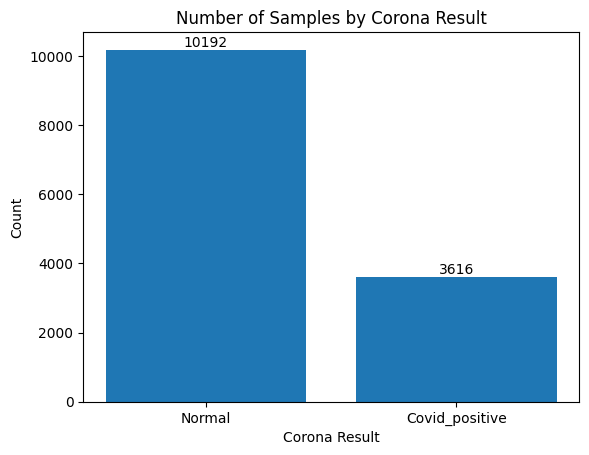

In [4]:
no_of_samples = 13808
df = pd.DataFrame()
df['corona_result'] = ['Normal', 'Covid_positive']
df['Count'] = [len(data[data['corona_result'] == 'Normal']), len(data[data['corona_result'] == 'Covid_positive'])]
df = df.sort_values(by = ['Count'], ascending = False)

plt.bar(df['corona_result'], df['Count'])
plt.xlabel('Corona Result')
plt.ylabel('Count')
plt.title('Number of Samples by Corona Result')

# Add labels outside the bars
for i, count in enumerate(df['Count']):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

In [5]:
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

In [6]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(0, no_of_samples):
    mean_val.append(data['image'][i].mean())
    std_dev_val.append(np.std(data['image'][i]))
    max_val.append(data['image'][i].max())
    min_val.append(data['image'][i].min())

imageEDA = data.loc[:,['image','corona_result','path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

imageEDA['subt_mean'] = imageEDA['mean'].mean() - imageEDA['mean']

In [7]:
mean_normal = imageEDA["mean"].loc[(imageEDA["corona_result"] == "Normal")].to_numpy()
mean_covid = imageEDA["mean"].loc[(imageEDA["corona_result"] == "Covid_positive")].to_numpy()
mean_opacity = imageEDA["mean"].loc[(imageEDA["corona_result"] == "Lung_Opacity")].to_numpy()
mean_pneumonia = imageEDA["mean"].loc[(imageEDA["corona_result"] == "Viral_Pneumonia")].to_numpy()
mean_list = [mean_normal,mean_covid,mean_opacity,mean_pneumonia]

max_normal = imageEDA["max"].loc[(imageEDA["corona_result"] == "Normal")].to_numpy()
max_covid = imageEDA["max"].loc[(imageEDA["corona_result"] == "Covid_positive")].to_numpy()
max_opacity = imageEDA["max"].loc[(imageEDA["corona_result"] == "Lung_Opacity")].to_numpy()
max_pneumonia = imageEDA["max"].loc[(imageEDA["corona_result"] == "Viral_Pneumonia")].to_numpy()
max_list = [max_normal,max_covid,max_opacity,max_pneumonia]

min_normal = imageEDA["min"].loc[(imageEDA["corona_result"] == "Normal")].to_numpy()
min_covid = imageEDA["min"].loc[(imageEDA["corona_result"] == "Covid_positive")].to_numpy()
min_opacity = imageEDA["min"].loc[(imageEDA["corona_result"] == "Lung_Opacity")].to_numpy()
min_pneumonia = imageEDA["min"].loc[(imageEDA["corona_result"] == "Viral_Pneumonia")].to_numpy()
min_list = [min_normal,min_covid,min_opacity,min_pneumonia]

std_normal = imageEDA["stedev"].loc[(imageEDA["corona_result"] == "Normal")].to_numpy()
std_covid = imageEDA["stedev"].loc[(imageEDA["corona_result"] == "Covid_positive")].to_numpy()
std_opacity = imageEDA["stedev"].loc[(imageEDA["corona_result"] == "Lung_Opacity")].to_numpy()
std_pneumonia = imageEDA["stedev"].loc[(imageEDA["corona_result"] == "Viral_Pneumonia")].to_numpy()
std_list = [std_normal,std_covid,std_opacity,std_pneumonia]

Names = ['Normal','Covid','Lung opacity','Pneumonia']

In [26]:
def min_max_plot(data, names, title):
    colors = ['#04EEFF', '#4BBBFF', '#F5F232', '#7FFF00']
    
    # Create subplots with a shared y-axis
    fig, ax = plt.subplots()
    
    # Iterate over the data and names
    for i in range(len(data)):
        # Check if the data list is not empty
        if len(data[i]) > 0:
            bins = np.linspace(min(data[i]), max(data[i]), 50)  # Define the bin edges for the histogram
            
            # Create the histogram for each set of data
            ax.hist(data[i], bins=bins, density=True, alpha=0.5, color=colors[i % len(colors)], label=names[i])
    
    ax.set_xlabel('Values')
    ax.set_ylabel('Density')
    ax.set_title(title)
    ax.legend()
    
    plt.show()

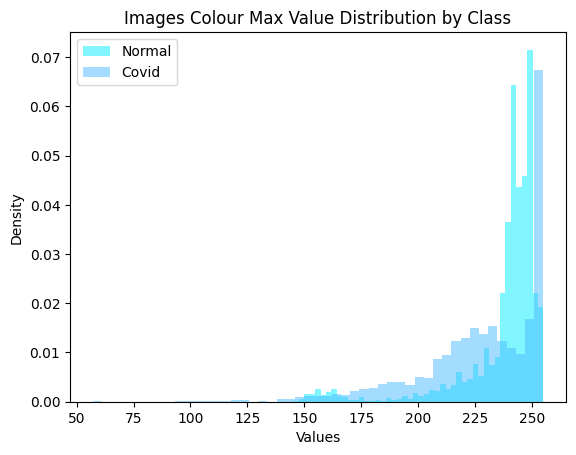

In [27]:
min_max_plot(max_list,Names,"Images Colour Max Value Distribution by Class")

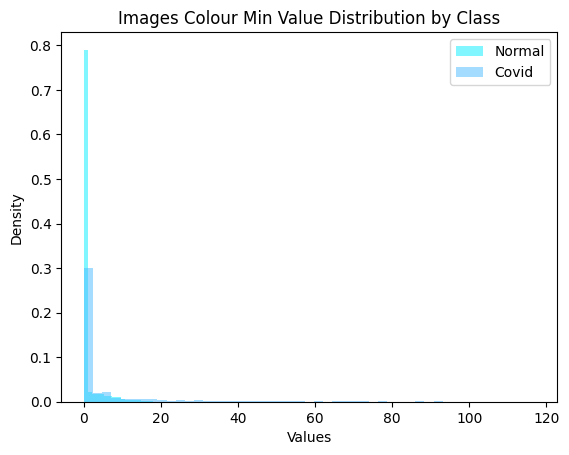

In [28]:
min_max_plot(min_list,Names,"Images Colour Min Value Distribution by Class")

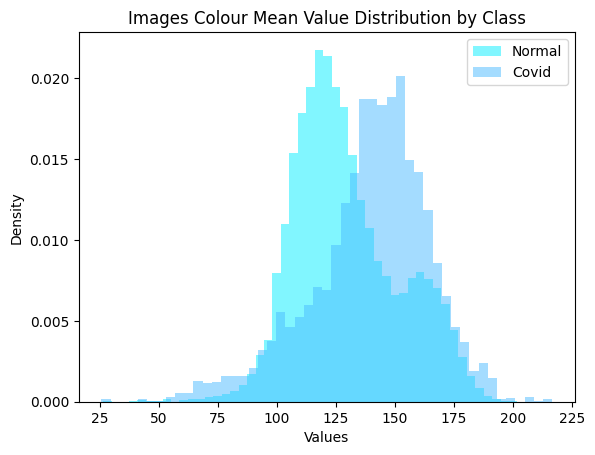

In [29]:
min_max_plot(mean_list,Names,"Images Colour Mean Value Distribution by Class")

In [12]:
def generate_dataset_from_directory(folder_path, size = 128,batch_size = 32): 

    image_generator = ImageDataGenerator(
        samplewise_center=True, 
        samplewise_std_normalization= True, 
        rescale=1./255,
        validation_split = 0.3
    )

    #create training and testing datasets
    train_data = image_generator.flow_from_directory(directory = 
        folder_path,
        class_mode="categorical",
        color_mode="grayscale",
        target_size = (size, size),
        batch_size  = batch_size,
                                                     
        shuffle=True,
        seed=123,
        subset="training"
    )

    #create training and testing datasets
    val_data = image_generator.flow_from_directory(directory = 
        folder_path,
        class_mode="categorical",
        color_mode="grayscale",
        target_size = (size, size),
        batch_size  = batch_size,
        shuffle=True,
        seed=123,
        subset="validation"
    )

    return train_data, val_data

def get_filepath_from_generator(gen):
    if gen.batch_index <=0:
        raise ValueError('Use iterator to move to batch_index > 0')
    idx_l = (gen.batch_index - 1) * gen.batch_size
    idx_r = idx_l + gen.batch_size if idx_l >= 0 else None
    indices = gen.index_array[idx_l:idx_r]
    filenames = [gen.filenames[i] for i in indices]
    return indices, filenames
    



In [13]:
folder_path = '//media//aaron//Local Disk//ANN//COVID-19 Radiography Database//COVID-19_Radiography_Dataset//'
train_data, val_data = generate_dataset_from_directory(
    folder_path, size = 128,batch_size = 32)

Found 19332 images belonging to 2 classes.
Found 8284 images belonging to 2 classes.


In [14]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig, ax = plt.subplots(1,2,figsize=(20,10))
  ax[0].plot(epochRange,history.history['accuracy'],'b',label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],'r',label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch', fontsize = 20)
  ax[0].set_ylabel('Accuracy', fontsize = 20)
  ax[0].legend()
  ax[0].grid(color='gray', linestyle='--')
  ax[1].plot(epochRange,history.history['loss'],'b',label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],'r',label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch', fontsize = 20)
  ax[1].set_ylabel('Loss', fontsize = 20)
  ax[1].legend()
  ax[1].grid(color='gray', linestyle='--')
  plt.show()

In [15]:
def cnn_model(train_data,test_data, epochs,size):
    print("----Building the model----")
    i = Input(shape=(size, size, 1))  # defining input
    x = BatchNormalization()(i)
    x = Conv2D(64, 3, activation='relu')(x)  # increase filters to 64
    x = MaxPooling2D()(x)
    x = Dropout(0.25)(x)  # increase dropout to 0.25

    x = Conv2D(128, 3, activation='relu')(x)  # increase filters to 128
    x = Conv2D(128, 3, activation='relu')(x)  # add another convolutional layer
    x = MaxPooling2D()(x)
    x = Dropout(0.25)(x)

 

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)  # increase number of units to 512
    x = Dropout(0.25)(x) 


    x = Dense(2, activation='softmax')(x)

    model = Model(i,x)
    model.summary()
#Training the Convolutional Neural Network
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience = 5 ,
                               restore_best_weights=True)
    #model_checkpoint
    mc = ModelCheckpoint('cnn_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    r = model.fit(train_data, 
                  validation_data = val_data, 
                  epochs = epochs, 
                  verbose = 1,
                  batch_size = 32,
                  callbacks = [early_stop,mc])
    print("Train score:", model.evaluate(train_data))
    print("Test score:", model.evaluate(val_data))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 
    

In [17]:
epochs = 20
r,model,n_epochs = cnn_model(train_data, val_data,epochs,128)

----Building the model----
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 1)      4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None

2023-07-26 09:04:08.635414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-26 09:04:08.665899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-26 09:04:08.666230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-26 09:04:08.667447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

----Training the network----
Epoch 1/20


2023-07-26 09:04:11.782579: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-07-26 09:04:13.003371: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-26 09:04:13.004266: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-26 09:04:13.004293: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-07-26 09:04:13.004839: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-26 09:04:13.004917: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-07-26 09:04:14.891676: I tensorflow/stream_executor/cuda/c

605/605 [==============================] - ETA: 0s - loss: 0.4836 - accuracy: 0.7732

2023-07-26 09:05:42.662775: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 220463104 exceeds 10% of free system memory.
2023-07-26 09:05:43.000736: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 220463104 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 0.32645, saving model to cnn_model.h5


2023-07-26 09:05:43.398926: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 220463104 exceeds 10% of free system memory.
2023-07-26 09:05:43.869165: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 220463104 exceeds 10% of free system memory.
2023-07-26 09:05:44.182444: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 220463104 exceeds 10% of free system memory.


605/605 [==============================] - 95s 144ms/step - loss: 0.4836 - accuracy: 0.7732 - val_loss: 0.3265 - val_accuracy: 0.8681
Epoch 2/20
605/605 [==============================] - ETA: 0s - loss: 0.3888 - accuracy: 0.8251
Epoch 2: val_loss improved from 0.32645 to 0.27422, saving model to cnn_model.h5
605/605 [==============================] - 81s 134ms/step - loss: 0.3888 - accuracy: 0.8251 - val_loss: 0.2742 - val_accuracy: 0.8865
Epoch 3/20
605/605 [==============================] - ETA: 0s - loss: 0.3462 - accuracy: 0.8502
Epoch 3: val_loss improved from 0.27422 to 0.26715, saving model to cnn_model.h5
605/605 [==============================] - 81s 134ms/step - loss: 0.3462 - accuracy: 0.8502 - val_loss: 0.2672 - val_accuracy: 0.8835
Epoch 4/20
605/605 [==============================] - ETA: 0s - loss: 0.3155 - accuracy: 0.8652
Epoch 4: val_loss improved from 0.26715 to 0.21340, saving model to cnn_model.h5
605/605 [==============================] - 80s 132ms/step - loss: 0

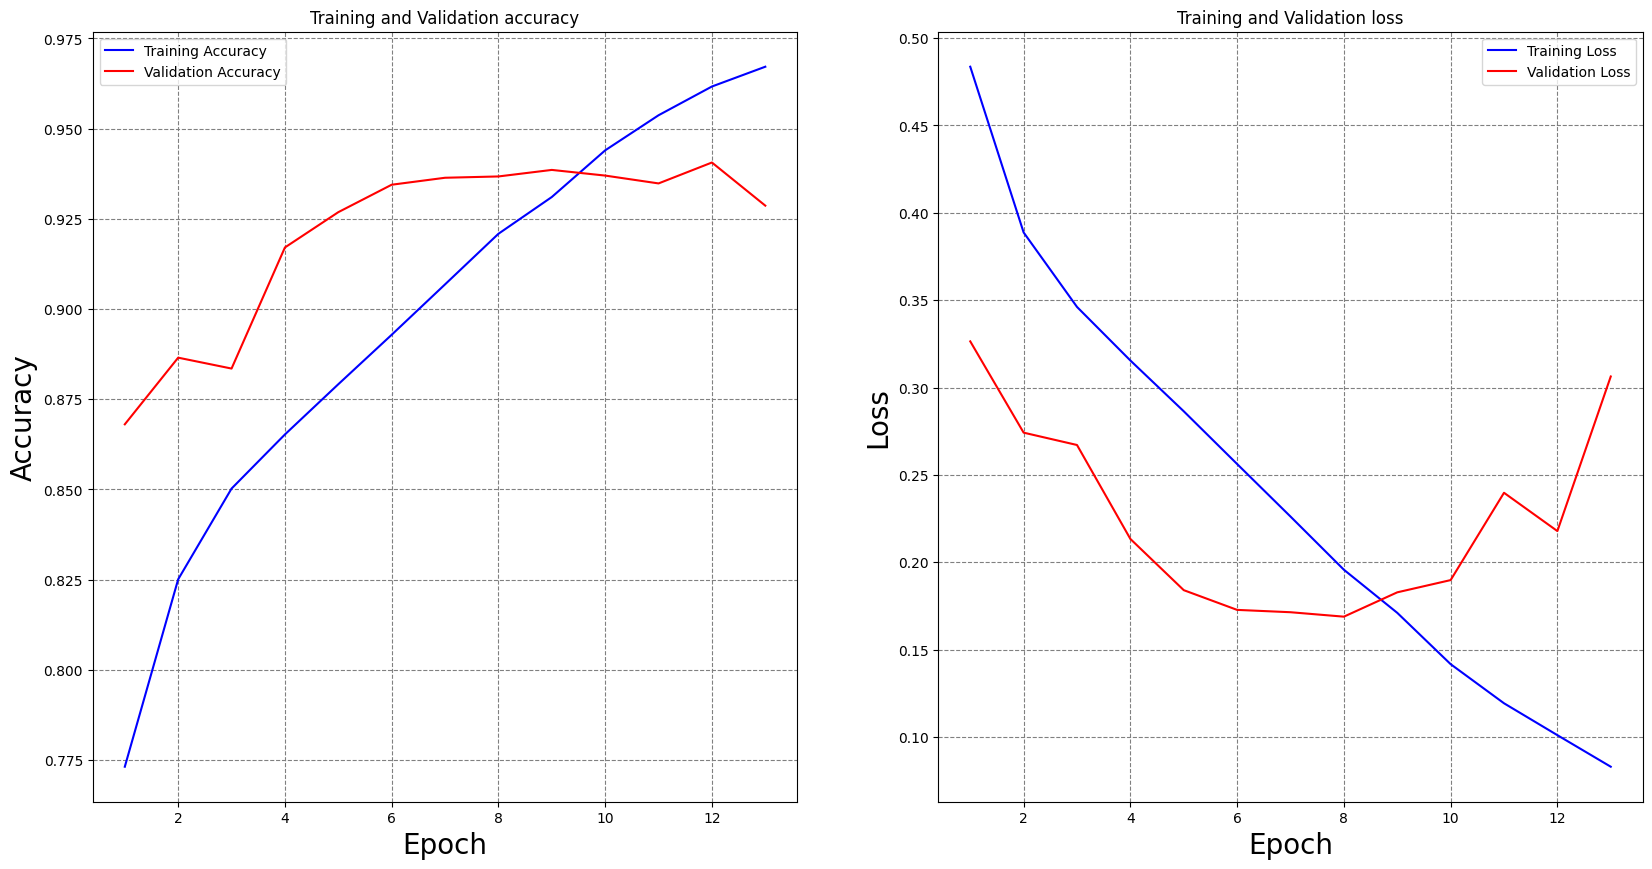

In [18]:
plotLearningCurve(r,n_epochs)

In [19]:
# printing model accuracy for train and test data
test_evaluation = model.evaluate(val_data)
print(f"Test Accuracy using CNN: {test_evaluation[1] * 100:.2f}%")

train_evaluation = model.evaluate(train_data)
print(f"Train Accuracy using CNN: {train_evaluation[1] * 100:.2f}%")

259/259 [==============================] - 12s 48ms/step - loss: 0.1689 - accuracy: 0.9367
Test Accuracy using CNN: 93.67%
605/605 [==============================] - 21s 34ms/step - loss: 0.1385 - accuracy: 0.9495
Train Accuracy using CNN: 94.95%


In [20]:
def extract_from_generator(data):
    data.reset()
    X, y = next(data)
    for i in tqdm.tqdm(range(int(data.n/data.batch_size)-1)): 
        img, label = next(data)
        X = np.append(X, img, axis=0 )
        y = np.append(y, label, axis=0)
    return X,y


In [21]:
X_train,y_train = extract_from_generator(train_data)
print('X_train:',X_train.shape,'y_train:',y_train.shape)

100%|██████████████████████████████████████████| 603/603 [02:35<00:00,  3.87it/s]

X_train: (19328, 128, 128, 1) y_train: (19328, 2)


In [22]:
X_test,y_test = extract_from_generator(val_data)
print('X_test:',X_test.shape,'y_test:',y_test.shape)

100%|██████████████████████████████████████████| 257/257 [00:37<00:00,  6.83it/s]

X_test: (8256, 128, 128, 1) y_test: (8256, 2)


In [23]:
y_pred  = np.round(model.predict(X_test))

258/258 [==============================] - 7s 26ms/step


In [24]:
y_test_c = np.argmax(y_test,axis = 1) 
y_pred_c = np.argmax(y_pred,axis = 1)

In [25]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      2167
           1       0.96      0.95      0.96      6089

   micro avg       0.94      0.94      0.94      8256
   macro avg       0.92      0.92      0.92      8256
weighted avg       0.94      0.94      0.94      8256
 samples avg       0.94      0.94      0.94      8256

